In [1]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *
import seaborn as sns, numpy as np
import functools
from scipy.spatial.distance import squareform
import math

### IMPORTS

In [2]:
from Inference.Variational import MeanFieldVariationalDistribution

In [3]:
class VariationalGenerativeNetwork(nn.Module):
    def __init__(self, nntransform, lat_dim, mu=0.0, sigma=1.0, device='cpu'):
        super(VariationalGenerativeNetwork, self).__init__()
        self.device = device
        self.lat_dim = lat_dim
        
        self.mfvar = MeanFieldVariationalDistribution(lat_dim,mu,sigma, device)
        self.nntransform = nntransform
        
          
    def sample(self, n=1):
        return self.nntransform(self.mfvar.sample(n))

In [4]:
def show_variational_posterior_predictive(q):
    x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
    # Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    plt.xlim(-2, 2) 
    plt.ylim(-4, 4) 
    plt.scatter(x_data.cpu(), y_data.cpu())
    for _ in range(1000):
        z = q.sample()
        set_all_parameters(model, z)
        y_test = model(x_test)

        plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [5]:
# Find what device to work with
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device 

device(type='cuda', index=2)

In [6]:
torch.set_default_dtype(torch.float64)

# Model principal

In [87]:
Target = torch.distributions.MultivariateNormal(torch.zeros(2, device=device), torch.tensor([[1,0.9],[0.9,1]], device=device))

In [219]:
def logposterior(x):
    n = torch.zeros(x.size(),device=device)
    n[:,0] = x[:,0]
    n[:,1] = x[:,0]**2 + x[:,1] + 1
    return Target.log_prob(n)

In [220]:
delta = 0.1
xi = torch.arange(-2.5, 3.0, delta, device=device)
yi = torch.arange(-8.0, 2.0, delta, device=device)
Xi, Yi = torch.meshgrid(xi, yi)
Zi = torch.zeros((Yi.shape), device=device)

In [221]:
for i in range(len(xi)):
    for j in range(len(yi)):
        Zi[i,j] = logposterior(torch.tensor([Xi[i,j],Yi[i,j]], device=device).unsqueeze(0)).exp()

<a list of 6 text.Text objects>

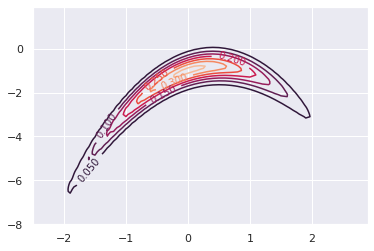

In [222]:
fig, ax = plt.subplots()
CS = ax.contour(Xi.detach().cpu().numpy(), Yi.detach().cpu().numpy(), Zi.detach().cpu().numpy())
ax.clabel(CS, inline=1, fontsize=10)

# Modèle génératif: Hypernet autoencodeur

In [ ]:
def LinSigmoid(x):
    return 1/(1+(math.e**-x)) + 0.05*x

In [ ]:
def LinTanh(x):
    return torch.tanh(x) + 0.05*x

In [ ]:
def LinELU(x):
    return torch.nn.functional.elu(x) + 0.01*x + 1.0

In [ ]:
def RBF(x):
    return torch.exp(-x**2)

In [ ]:
def RectifiedQuad(x):
    return nn.functional.relu(x)**2

In [ ]:
def swish(x, beta = 1):
    return (x * torch.sigmoid(beta * x))

In [ ]:
plt.plot(x_lin.detach().cpu().numpy(), LinELU(x_lin).detach().cpu().numpy())

In [241]:
class Net(nn.Module):
    def __init__(self,lat_dim, H):
        super(Net, self).__init__()
        self.L1 = nn.Linear(lat_dim, H)
        self.L2 = nn.Linear(H, H)
        self.L3 = nn.Linear(H, H)
        self.L4 = nn.Linear(H, H)
        self.L5 = nn.Linear(H, H)
        self.L6 = nn.Linear(H, 2)

    def forward(self, input):
        h = nn.functional.relu(self.L1(input))
        h = nn.functional.relu(self.L2(h))
        h = nn.functional.relu(self.L3(h))
        h = nn.functional.relu(self.L4(h))
        h = nn.functional.relu(self.L5(h))
        h = self.L6(h)
        return h
    
lat_dim = 20
H = 50
nntransform = Net(lat_dim,H)
nntransform.to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        #torch.nn.init.normal_(m.weight, mean=0.0, std=0.2)
        #torch.nn.init.normal_(m.bias, mean=0.0, std=0.2)
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.uniform_(m.bias)
        

nntransform.apply(init_weights)

q = VariationalGenerativeNetwork(nntransform, lat_dim, mu=0.0, sigma=1.0, device=device)
q.mfvar.mu.requires_grad_(False)
q.mfvar.rho.requires_grad_(False)

Parameter containing:
tensor([0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413, 0.5413,
        0.5413, 0.5413], device='cuda:2')

In [ ]:
class PolynomialNet(nn.Module):
    def __init__(self,lat_dim, H):
        super(PolynomialNet, self).__init__()
        self.L1 = nn.Linear(lat_dim, H)
        self.L2 = nn.Linear(2*H, H)
        self.L3 = nn.Linear(2*H, H)
        self.L4 = nn.Linear(2*H, H)
        self.L5 = nn.Linear(2*H, H)
        self.L6 = nn.Linear(2*H, 1)

    def forward(self, input):
        h = torch.cat([nn.functional.relu(self.L1(input)), nn.functional.relu(self.L1(input))**2], dim=1) 
        h = torch.cat([nn.functional.relu(self.L2(h)), nn.functional.relu(self.L2(h))**2], dim=1) 
        h = torch.cat([nn.functional.relu(self.L3(h)), nn.functional.relu(self.L3(h))**2], dim=1)
        h = torch.cat([nn.functional.relu(self.L4(h)), nn.functional.relu(self.L4(h))**2], dim=1) 
        h = torch.cat([nn.functional.relu(self.L5(h)), nn.functional.relu(self.L5(h))**2], dim=1) 
        h = self.L6(h)
        return h
    
lat_dim = 10
H = 50
nntransform = PolynomialNet(lat_dim,H)
nntransform.to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.1)
        torch.nn.init.normal_(m.bias, mean=0.0, std=1.0)
        #torch.nn.init.xavier_uniform_(m.weight)
        #torch.nn.init.uniform_(m.bias)
        

nntransform.apply(init_weights)

q = VariationalGenerativeNetwork(nntransform, lat_dim, mu=0.0, sigma=1.0, device=device)
q.mfvar.mu.requires_grad_(False)
q.mfvar.rho.requires_grad_(False)

In [ ]:
class DenseBlockEncoder(torch.nn.Module):
    def __init__(self, wSequence, activation):
        super().__init__()
        self.fullyConnectedList = nn.ModuleList()
        self.activation = activation
        for j in range(len(wSequence) - 1):
            self.fullyConnectedList.append(nn.Linear(sum(wSequence[:j + 1]), wSequence[j + 1]))

    def forward(self, *inputs):
        hidden, = inputs
        for j in range(len(self.fullyConnectedList) - 1):
            layer = self.fullyConnectedList[j]
            hidden = self.activation(torch.cat([layer(hidden), hidden], dim=1))
        layer = self.fullyConnectedList[-1]
        hidden = layer(hidden)
        return hidden

lat_dim = 10
H = 20
nntransform = DenseBlockEncoder([lat_dim,H,H,H,H,1], nn.functional.relu)
nntransform.to(device)

def init_weights(m):
    if type(m) == nn.Linear:
        #torch.nn.init.normal_(m.weight, mean=0.0, std=0.2)
        #torch.nn.init.normal_(m.bias, mean=0.0, std=0.2)
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.uniform_(m.bias)
        

nntransform.apply(init_weights)

q = VariationalGenerativeNetwork(nntransform, lat_dim, mu=0.0, sigma=5.0, device=device)
q.mfvar.mu.requires_grad_(False)
q.mfvar.rho.requires_grad_(False)

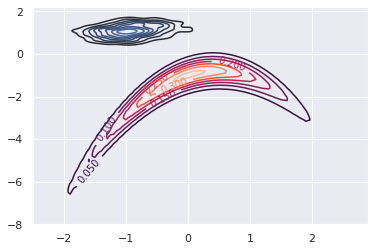

In [242]:
X = q.sample(1000)
fig, ax = plt.subplots()
CS = ax.contour(Xi.detach().cpu().numpy(), Yi.detach().cpu().numpy(), Zi.detach().cpu().numpy())
ax.clabel(CS, inline=1, fontsize=10)
ax = sns.kdeplot(X[:,0].detach().cpu().numpy(), X[:,1].detach().cpu().numpy())

# Training #

In [243]:
N_ELBO = 1200

In [244]:
optimizer = torch.optim.Adagrad(q.parameters(), lr=0.02)

In [245]:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, factor=0.1)

In [246]:
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9995)

In [249]:
%matplotlib inline
liveloss = PlotLosses()

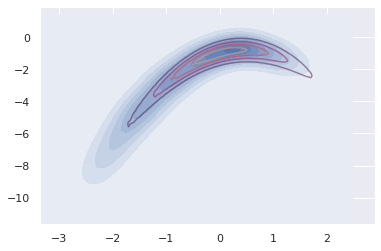

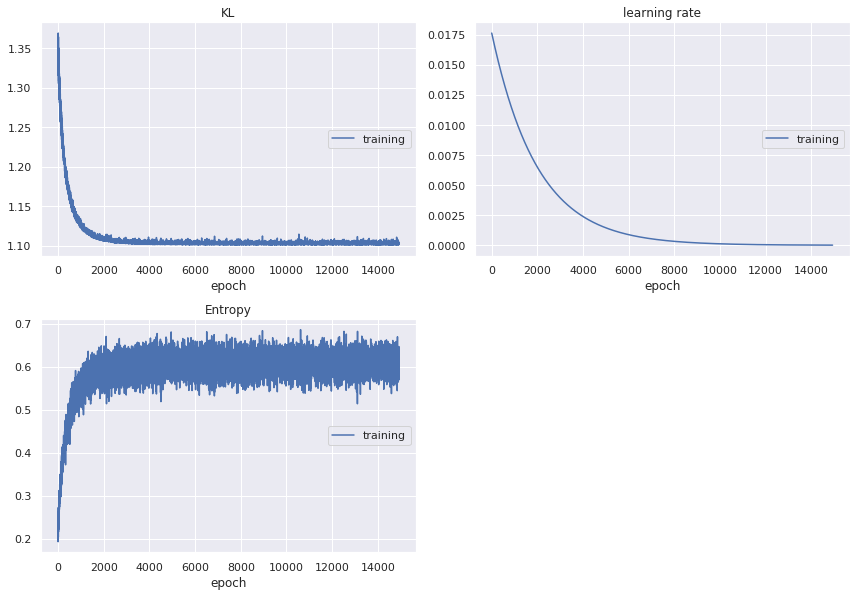

KL:
training   (min:    1.101, max:    1.371, cur:    1.102)

learning rate:
training   (min:    0.000, max:    0.018, cur:    0.000)

Entropy:
training   (min:    0.193, max:    0.686, cur:    0.584)


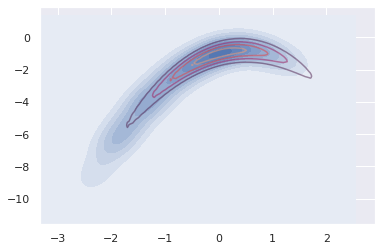

In [250]:
for t in range(100000):
    with torch.autograd.set_detect_anomaly(True):
        logs = {}
        optimizer.zero_grad()

        X = q.sample(N_ELBO)
        ExpectedPosterior = logposterior(X).mean()

        D = torch.nn.functional.pdist(X,p=2.0)

        Entropy = torch.log(D).mean()

        L = -ExpectedPosterior-Entropy

        if not torch.isfinite(L):
            break

        L.backward(retain_graph=True)
        torch.nn.utils.clip_grad_value_(q.parameters(), 0.01)

        optimizer.step()

        with torch.no_grad():
            learning_rate = optimizer.param_groups[0]['lr']

            scheduler.step() #L.detach().clone().cpu().numpy())

            logs['KL'] = L.detach().clone().cpu().numpy()
            logs['learning rate'] = learning_rate
            logs['Entropy'] = Entropy.detach().clone().cpu().numpy()
            liveloss.update(logs)

            if t % 25 == 0:
                liveloss.draw()
                X = q.sample(1000)
                fig, ax = plt.subplots()
                ax.contour(Xi.detach().cpu().numpy(), Yi.detach().cpu().numpy(), Zi.detach().cpu().numpy(), levels=5, alpha=0.5)
                #ax.clabel(CS, inline=1, fontsize=10)
                ax = sns.kdeplot(X[:,0].detach().cpu().numpy(), X[:,1].detach().cpu().numpy(), shade=True)

        if learning_rate < 0.00001:
            break